In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import xarray as xr
from pathlib import Path
from matplotlib import pyplot as plt
from time import perf_counter

In [2]:
ds = xr.open_dataset(Path.home() / 'research_data/GLP/synthetic_data/init_ds.nc')

In [3]:
class OutputScaler:
    def __init__(self, y):
        self.means = []
        self.stds = []
        self.num_features = y.shape[-1]
        for i in range(self.num_features):
            self.means.append(y[..., i].mean())
            self.stds.append(y[..., i].std())
            
    def transform(self, y_vals):
        self.y_scaled = y_vals.copy()
        for i in range(self.num_features):
            self.y_scaled[..., i] = (self.y_scaled[..., i] - self.means[i])/self.stds[i]
        return self.y_scaled
    
    def untransform(self, y_vals):
        self.y_unscaled = y_vals.copy()
        for i in range(self.num_features):
            self.y_unscaled[..., i] = self.y_unscaled[..., i]*self.stds[i] + self.means[i]
        return self.y_unscaled

In [4]:
ds_scaler = OutputScaler(np.stack([ds.maj_len.values, ds.min_len.values]).T)
ds['target'] = (('p', 'axis'), ds_scaler.transform(np.stack([ds.maj_len.values, ds.min_len.values]).T))

In [5]:
ds

<xarray.Dataset>
Dimensions:   (p: 10000, x: 128, y: 128, axis: 2)
Coordinates:
  * x         (x) int32 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * y         (y) int32 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
Dimensions without coordinates: p, axis
Data variables:
    ellipse   (p, x, y) float64 ...
    maj_len   (p) float64 27.24 25.74 26.25 32.18 ... 35.75 22.03 13.99 38.75
    min_len   (p) float64 17.63 12.59 16.9 7.789 ... 17.05 5.637 7.559 22.99
    angle     (p) float64 ...
    center_x  (p) float64 ...
    center_y  (p) float64 ...
    target    (p, axis) float64 0.245 1.431 0.07126 ... -0.7029 1.58 2.566

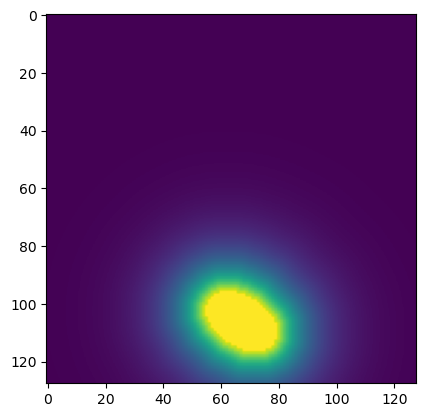

In [6]:
plt.imshow(ds.ellipse[0, :, :].values)

In [7]:
# Create custom dataset method
class SynthDataset(Dataset):
    def __init__(self, full_ds, start_idx=None, end_idx=None, transform=None, target_transform=None):
        self.full_ds = full_ds.isel(p=slice(start_idx, end_idx))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.full_ds.p.shape[0]

    def __getitem__(self, idx):
        image = torch.unsqueeze(torch.tensor(self.full_ds.ellipse[idx, :, :].values.astype(np.float32)), 0)
        label = torch.tensor(self.full_ds.target.isel(p=idx).values.astype(np.float32))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## CNN

In [21]:
cnn_train_ds = SynthDataset(ds, end_idx=8000)
cnn_val_ds = SynthDataset(ds, start_idx=8000)

batch_size = 32
cnn_train_dataloader = DataLoader(cnn_train_ds, batch_size=batch_size, shuffle=True)
cnn_val_dataloader = DataLoader(cnn_val_ds, batch_size=batch_size, shuffle=True)

In [22]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_encoding = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.dense_stack = nn.Sequential(
            nn.Linear(8*8*128, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        latent = self.conv_encoding(x)
        latent = self.flatten(latent)
        preds = self.dense_stack(latent)
        return preds

cnn_model = CNN().to(device)
print(cnn_model)

cnn_loss_fn = nn.MSELoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

Using cuda device
CNN(
  (conv_encoding): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (13): ReLU()
  )
  (flatten): Flatten(start_dim=1, end

In [23]:
def cnn_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def cnn_validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Validation avg loss: {test_loss:>8f}")

In [24]:
epochs = 10
print("Training CNN \n")
t_time_start = perf_counter()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = perf_counter()
    cnn_train(cnn_train_dataloader, cnn_model, cnn_loss_fn, cnn_optimizer)
    cnn_validate(cnn_val_dataloader, cnn_model, cnn_loss_fn)
    print(f"Epoch time: {perf_counter() - start_time:.2f} seconds \n")
t_time = perf_counter() - t_time_start
print(f"Done! Total training time: {t_time // 60:.0f} minutes, {t_time % 60:.2f} seconds, average epoch time: {t_time/epochs:.2f} seconds")

Training CNN 

Epoch 1
-------------------------------
loss: 0.892682  [   32/ 8000]
loss: 0.500015  [ 1056/ 8000]
loss: 0.306870  [ 2080/ 8000]
loss: 0.222172  [ 3104/ 8000]
loss: 0.194836  [ 4128/ 8000]
loss: 0.200361  [ 5152/ 8000]
loss: 0.234937  [ 6176/ 8000]
loss: 0.152505  [ 7200/ 8000]
Validation avg loss: 0.177544
Epoch time: 6.39 seconds 

Epoch 2
-------------------------------
loss: 0.158802  [   32/ 8000]
loss: 0.228962  [ 1056/ 8000]
loss: 0.221897  [ 2080/ 8000]
loss: 0.191250  [ 3104/ 8000]
loss: 0.178295  [ 4128/ 8000]
loss: 0.131860  [ 5152/ 8000]
loss: 0.227519  [ 6176/ 8000]
loss: 0.263337  [ 7200/ 8000]
Validation avg loss: 0.173302
Epoch time: 5.88 seconds 

Epoch 3
-------------------------------
loss: 0.102877  [   32/ 8000]
loss: 0.186137  [ 1056/ 8000]
loss: 0.247262  [ 2080/ 8000]
loss: 0.185825  [ 3104/ 8000]
loss: 0.165193  [ 4128/ 8000]
loss: 0.145669  [ 5152/ 8000]
loss: 0.141576  [ 6176/ 8000]
loss: 0.154127  [ 7200/ 8000]
Validation avg loss: 0.159101
E

In [30]:
test_sample = torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0)
with torch.no_grad():
    print(ds_scaler.untransform(cnn_model(test_sample.to(device)).detach().cpu().numpy()))

[[37.636436 17.359415]]


In [31]:
(ds.isel(p=8005).maj_len.item(), ds.isel(p=8005).min_len.item())

(36.019580126633315, 19.431750325270166)

In [33]:
cnn_preds = []
for i in range(360):
    test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), i)
    with torch.no_grad():
        cnn_preds.append(ds_scaler.untransform(cnn_model(test_sample.to(device)).detach().cpu().numpy())[0])
cnn_preds = np.array(cnn_preds)

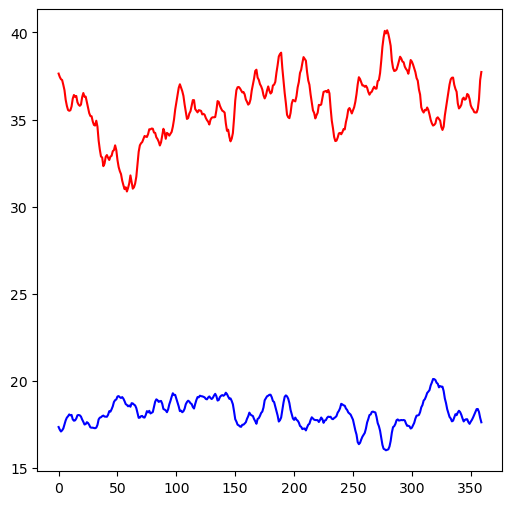

In [35]:
F, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(cnn_preds[:, 0], color='red')
ax.plot(cnn_preds[:, 1], color='blue')

## Augmented CNN

In [25]:
aug_cnn_train_ds = SynthDataset(ds, end_idx=8000, transform=transforms.RandomRotation(180))
aug_cnn_val_ds = SynthDataset(ds, start_idx=8000, transform=transforms.RandomRotation(180))

batch_size = 32
aug_cnn_train_dataloader = DataLoader(aug_cnn_train_ds, batch_size=batch_size, shuffle=True)
aug_cnn_val_dataloader = DataLoader(aug_cnn_val_ds, batch_size=batch_size, shuffle=True)

In [26]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_encoding = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.dense_stack = nn.Sequential(
            nn.Linear(8*8*128, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        latent = self.conv_encoding(x)
        latent = self.flatten(latent)
        preds = self.dense_stack(latent)
        return preds

aug_cnn_model = CNN().to(device)
print(aug_cnn_model)

aug_cnn_loss_fn = nn.MSELoss()
aug_cnn_optimizer = torch.optim.Adam(aug_cnn_model.parameters(), lr=0.001)

Using cuda device
CNN(
  (conv_encoding): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (13): ReLU()
  )
  (flatten): Flatten(start_dim=1, end

In [27]:
def aug_cnn_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for dummy in range(4):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 32 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def aug_cnn_validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Validation avg loss: {test_loss:>8f}")

In [28]:
epochs = 10
print("Training Augmented CNN \n")
t_time_start = perf_counter()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = perf_counter()
    aug_cnn_train(aug_cnn_train_dataloader, aug_cnn_model, aug_cnn_loss_fn, aug_cnn_optimizer)
    aug_cnn_validate(aug_cnn_val_dataloader, aug_cnn_model, aug_cnn_loss_fn)
    print(f"Epoch time: {perf_counter() - start_time:.2f} seconds \n")
t_time = perf_counter() - t_time_start
print(f"Done! Total training time: {t_time // 60:.0f} minutes, {t_time % 60:.2f} seconds, average epoch time: {t_time/epochs:.2f} seconds")

Training Augmented CNN 

Epoch 1
-------------------------------
loss: 1.062191  [   32/ 8000]
loss: 1.190253  [ 1056/ 8000]
loss: 0.654149  [ 2080/ 8000]
loss: 0.233811  [ 3104/ 8000]
loss: 0.120734  [ 4128/ 8000]
loss: 0.230668  [ 5152/ 8000]
loss: 0.147663  [ 6176/ 8000]
loss: 0.241509  [ 7200/ 8000]
loss: 0.220178  [   32/ 8000]
loss: 0.192019  [ 1056/ 8000]
loss: 0.273716  [ 2080/ 8000]
loss: 0.133182  [ 3104/ 8000]
loss: 0.232409  [ 4128/ 8000]
loss: 0.185239  [ 5152/ 8000]
loss: 0.211607  [ 6176/ 8000]
loss: 0.210717  [ 7200/ 8000]
loss: 0.196494  [   32/ 8000]
loss: 0.172524  [ 1056/ 8000]
loss: 0.165212  [ 2080/ 8000]
loss: 0.156149  [ 3104/ 8000]
loss: 0.207124  [ 4128/ 8000]
loss: 0.144645  [ 5152/ 8000]
loss: 0.211216  [ 6176/ 8000]
loss: 0.182908  [ 7200/ 8000]
loss: 0.149784  [   32/ 8000]
loss: 0.203835  [ 1056/ 8000]
loss: 0.332094  [ 2080/ 8000]
loss: 0.131353  [ 3104/ 8000]
loss: 0.159758  [ 4128/ 8000]
loss: 0.249904  [ 5152/ 8000]
loss: 0.151600  [ 6176/ 8000]
loss:

KeyboardInterrupt: 

In [23]:
test_sample = torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0)
with torch.no_grad():
    print(ds_scaler.untransform(aug_cnn_model(test_sample.to(device)).detach().cpu().numpy()))

[[37.315865 19.310345]]


In [24]:
(ds.isel(p=8005).maj_len.item(), ds.isel(p=8005).min_len.item())

(36.019580126633315, 19.431750325270166)

In [36]:
aug_cnn_preds = []
for i in range(360):
    test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), i)
    with torch.no_grad():
        aug_cnn_preds.append(ds_scaler.untransform(aug_cnn_model(test_sample.to(device)).detach().cpu().numpy())[0])
aug_cnn_preds = np.array(aug_cnn_preds)

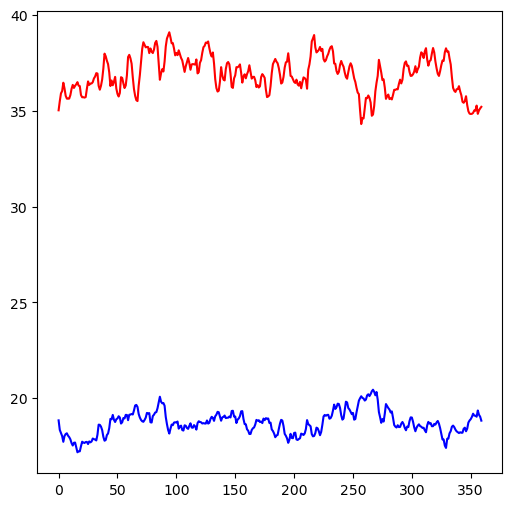

In [38]:
F, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(aug_cnn_preds[:, 0], color='red')
ax.plot(aug_cnn_preds[:, 1], color='blue')

## GLP CNN

In [8]:
class glp_transform(nn.Module):
    def __init__(self, num_angles=None, angle_inc=None):
        super().__init__()
        if (num_angles is None) and (angle_inc is None):
            raise ValueError('Need either num_angles or angle_inc to be defined')
        if num_angles is None:
            self.num_angles = 360 / angle_inc
            self.angle_inc = angle_inc
        else:
            self.angle_inc = 360 / num_angles
            self.num_angles = num_angles
        
    def __call__(self, image):
        temp_list = [transforms.functional.rotate(image, self.angle_inc*i) for i in range(int(self.num_angles))]
        return torch.stack(temp_list, dim=-1)

In [9]:
glp_train_ds = SynthDataset(ds, end_idx=8000, transform = glp_transform(angle_inc=45))
glp_val_ds = SynthDataset(ds, start_idx=8000, transform = glp_transform(angle_inc=45))

batch_size = 32
glp_train_dataloader = DataLoader(glp_train_ds, batch_size=batch_size, shuffle=True)
glp_val_dataloader = DataLoader(glp_val_ds, batch_size=batch_size, shuffle=True)

In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class glp_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_encoding = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=16, kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 1)),
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 1)),
            nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 1)),
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 1)),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.MaxPool3d(kernel_size=(1, 1, 2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.dense_stack = nn.Sequential(
            nn.Linear(8*8*128*4, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        latent = self.conv_encoding(x)
        latent = self.flatten(latent)
        preds = self.dense_stack(latent)
        return preds

glp_model = glp_CNN().to(device)
print(glp_model)

glp_loss_fn = nn.MSELoss()
glp_optimizer = torch.optim.Adam(glp_model.parameters(), lr=0.001)

Using cuda device
glp_CNN(
  (conv_encoding): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(16, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(32, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (7): ReLU()
    (8): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    (9): Conv3d(32, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(64, 128, kernel_size=(3, 3, 1), stri

In [11]:
def glp_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def glp_validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Validation avg loss: {test_loss:>8f}")

In [12]:
epochs = 10
print("Training GLP CNN \n")
t_time_start = perf_counter()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = perf_counter()
    glp_train(glp_train_dataloader, glp_model, glp_loss_fn, glp_optimizer)
    glp_validate(glp_val_dataloader, glp_model, glp_loss_fn)
    print(f"Epoch time: {perf_counter() - start_time:.2f} seconds \n")
t_time = perf_counter() - t_time_start
print(f"Done! Total training time: {t_time // 60:.0f} minutes, {t_time % 60:.2f} seconds, average epoch time: {t_time/epochs:.2f} seconds")

Training GLP CNN 

Epoch 1
-------------------------------
loss: 1.004137  [   32/ 8000]
loss: 0.861711  [ 1056/ 8000]
loss: 0.231827  [ 2080/ 8000]
loss: 0.327751  [ 3104/ 8000]
loss: 0.101532  [ 4128/ 8000]
loss: 0.218473  [ 5152/ 8000]
loss: 0.132566  [ 6176/ 8000]
loss: 0.119593  [ 7200/ 8000]
Validation avg loss: 0.178583
Epoch time: 232.38 seconds 

Epoch 2
-------------------------------
loss: 0.146120  [   32/ 8000]
loss: 0.155073  [ 1056/ 8000]
loss: 0.245939  [ 2080/ 8000]
loss: 0.112572  [ 3104/ 8000]
loss: 0.158061  [ 4128/ 8000]
loss: 0.178003  [ 5152/ 8000]
loss: 0.147180  [ 6176/ 8000]
loss: 0.200656  [ 7200/ 8000]
Validation avg loss: 0.157087
Epoch time: 131.39 seconds 

Epoch 3
-------------------------------
loss: 0.104284  [   32/ 8000]
loss: 0.111706  [ 1056/ 8000]
loss: 0.157589  [ 2080/ 8000]
loss: 0.138378  [ 3104/ 8000]
loss: 0.294341  [ 4128/ 8000]
loss: 0.114188  [ 5152/ 8000]
loss: 0.099186  [ 6176/ 8000]
loss: 0.143580  [ 7200/ 8000]
Validation avg loss: 0.


KeyboardInterrupt



In [13]:
(ds.isel(p=8005).maj_len.item(), ds.isel(p=8005).min_len.item())

(36.019580126633315, 19.431750325270166)

In [15]:
test_sample = torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0)
test_tf = glp_transform(angle_inc=45)
with torch.no_grad():
    print(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy()))

[[34.80786 18.95898]]


In [16]:
test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), 45)
test_tf = glp_transform(angle_inc=45)
with torch.no_grad():
    print(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy()))

[[33.96623  18.725128]]


In [17]:
test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), 90)
test_tf = glp_transform(angle_inc=45)
with torch.no_grad():
    print(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy()))

[[35.322998 19.12083 ]]


In [18]:
test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), 135)
test_tf = glp_transform(angle_inc=45)
with torch.no_grad():
    print(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy()))

[[34.947956 19.240837]]


In [19]:
test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), 15)
test_tf = glp_transform(angle_inc=45)
with torch.no_grad():
    print(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy()))

[[35.371887 18.752256]]


In [20]:
test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), 30)
test_tf = glp_transform(angle_inc=45)
with torch.no_grad():
    print(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy()))

[[34.97712  18.971527]]


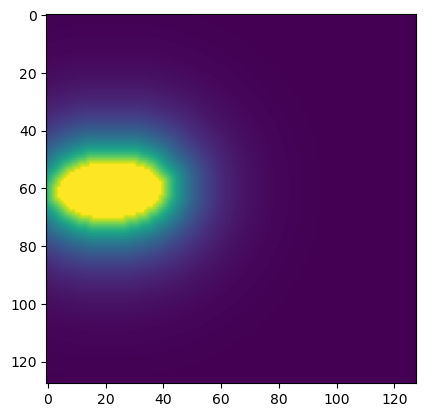

In [76]:
plt.imshow(test_sample[0, 0, :, :].numpy())

In [40]:
glp_preds = []
for i in range(360):
    test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(ds.ellipse[8005, :, :].values.astype(np.float32)), 0), 0), i)
    test_tf = glp_transform(angle_inc=45)
    with torch.no_grad():
        glp_preds.append(ds_scaler.untransform(glp_model(test_tf(test_sample.to(device))).detach().cpu().numpy())[0])
glp_preds = np.array(glp_preds)

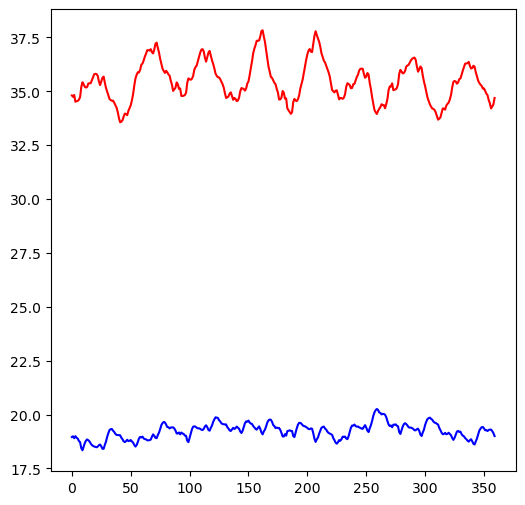

In [41]:
F, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(glp_preds[:, 0], color='red')
ax.plot(glp_preds[:, 1], color='blue')

Text(0.5, 1.0, 'GLP CNN')

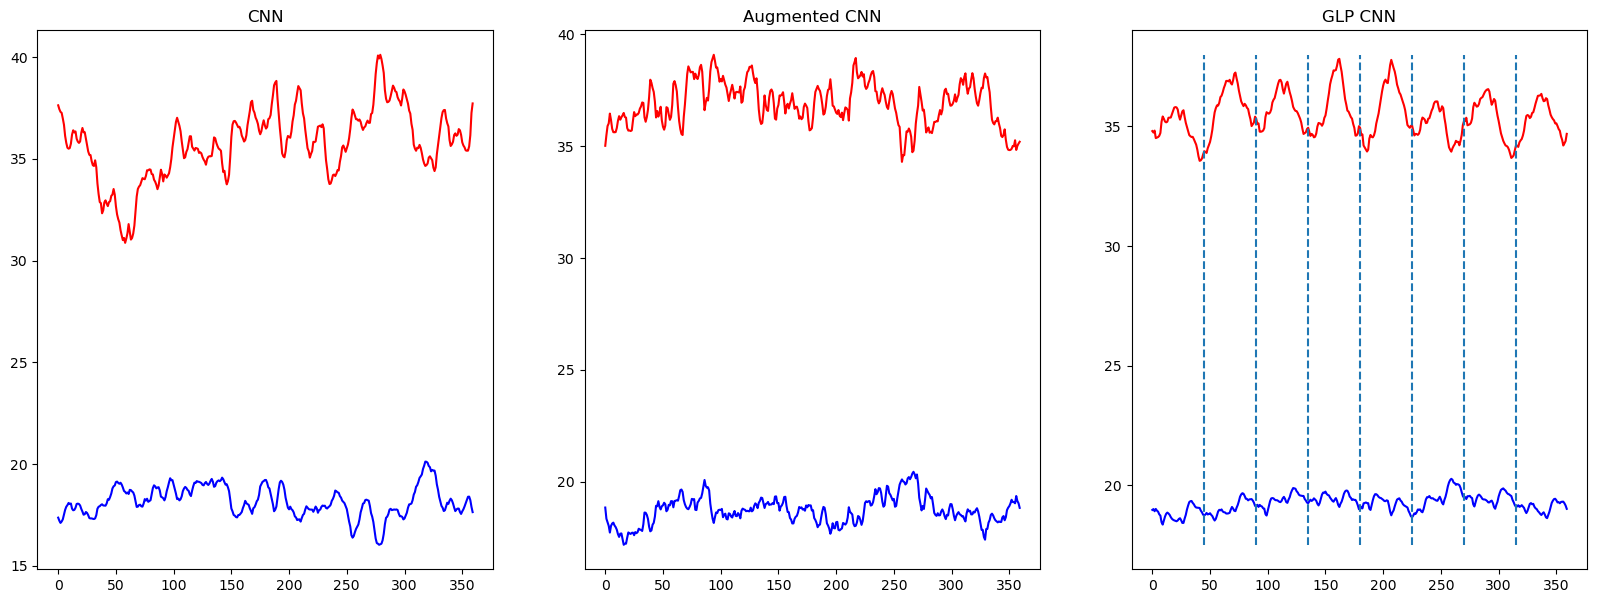

In [48]:
F, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(cnn_preds[:, 0], color='red')
ax[0].plot(cnn_preds[:, 1], color='blue')
ax[0].set_title('CNN')
ax[1].plot(aug_cnn_preds[:, 0], color='red')
ax[1].plot(aug_cnn_preds[:, 1], color='blue')
ax[1].set_title('Augmented CNN')
ax[2].plot(glp_preds[:, 0], color='red')
ax[2].plot(glp_preds[:, 1], color='blue')
ax[2].vlines([45, 90, 135, 180, 225, 270, 315], ymin=17.5, ymax=38, linestyle='dashed')
ax[2].set_title('GLP CNN')